# Forward folding

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
import arviz as av

from instrument_response.toy_simulation import ToySimulation
from instrument_response.detector import Response

In [2]:
random_seed = 1

## Simulation of the detection process

In order to characterise the response of a detector, we need to build a simulation for the detection process. Consider a simple calorimeter, such a simulation would have to include:
* Generation of incident particles
* Effective area of the dectector, or interaction probability of the incoming particles
* Production of secondary particles/photons and their interactions in the detector medium
* Dectection of some observable output of these interactions (e.g. photons in PMTs)

In the real world, these simulations are complex and usually handled by large software frameworks. For fun, we can look at how it works for a toy model which includes the above simulation steps (see `detector.py` for details). The ideas can easily be generalised to a more complex detector and its simulation.

In [3]:
# Run a simulation
# Want to see what goes on at high E without running forever
power_law_index = 1.0 

# Energy range of interest
min_energy = 1 # TeV
max_energy = 100 # TeV

simulation = ToySimulation(power_law_index, min_energy, max_energy)

In [4]:
# Run for large number of particles to generate response (~1 min)
response_file = 'output/response_sim.h5'

# Uncomment to run again, can just read file
#simulation.run(int(5e6), seed=random_seed)
#simulation.save(response_file)

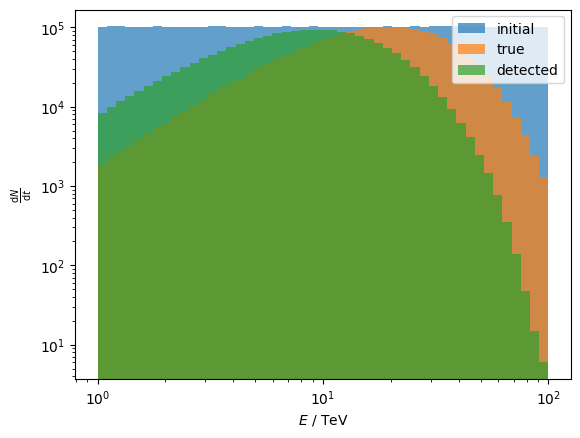

In [5]:
# Read in output to have a look
with h5py.File(response_file, 'r') as f:
    initial_energy = f["initial_energy"][()]
    true_energy = f["true_energy"][()]
    detected_energy = f["detected_energy"][()]
    
# Plot
bins = np.logspace(np.log(min_energy), np.log(max_energy), base=np.e)

fig, ax = plt.subplots();
ax.hist(initial_energy, bins=bins, alpha=0.7, label="initial")
ax.hist(true_energy, bins=bins, alpha=0.7, label="true");
ax.hist(detected_energy, bins=bins, alpha=0.7, label="detected");
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$E$ / TeV")
ax.set_ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}t}$")
ax.legend();

We can see how the injected energy spectrum changes through different stages of the simulation. The *initial* spectrum is that incident upon the detector, the *true* spectrum is that taking into account the effective area (or interaction probability) and the *detected* is that registered in the detector. In order to compare a model to data, we need to quantify the changes in each of these steps.

## Generating the response matrix

Now that we have a suitable simulation, we can extract the output to build the response matrix. This matrix basically gives us the expected event rate in a 2D bin (initial energy, detected energy), for a given incoming flux.

We start by quantifying the effective area using the initial and true energies. This is just the area of each energy bin.

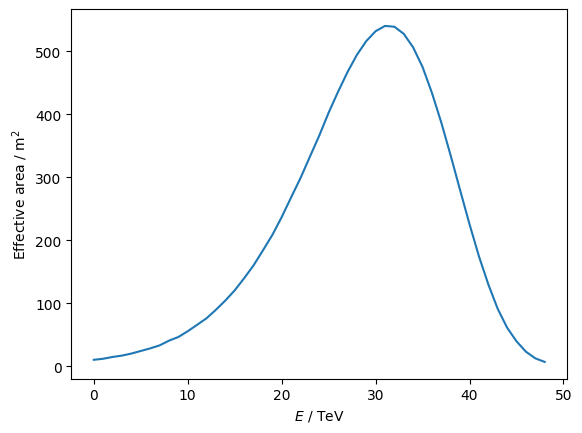

In [6]:
counts_init, _ = np.histogram(initial_energy, bins=bins) # Counts incidence on the detector
counts_true, _ = np.histogram(true_energy, bins=bins) # Counts interacting in detector

fig, ax = plt.subplots()
ax.plot(counts_true / counts_init * simulation.effective_area.maximum)
ax.set_xlabel("$E$ / TeV")
ax.set_ylabel("Effective area / $\mathrm{m}^2$");

Now, we want to quantify the energy dispersion. To get this from the simulation, we make a 2D histogram of the true energies and detected energies, then for each bin we divide by the event rate in the true spectrum and multiply by the effective area. This is done in the `Response` class. Here we work with a joint response matrix for both the effective area and the energy dispersion, thus it has units of $\rm{m}^2$.

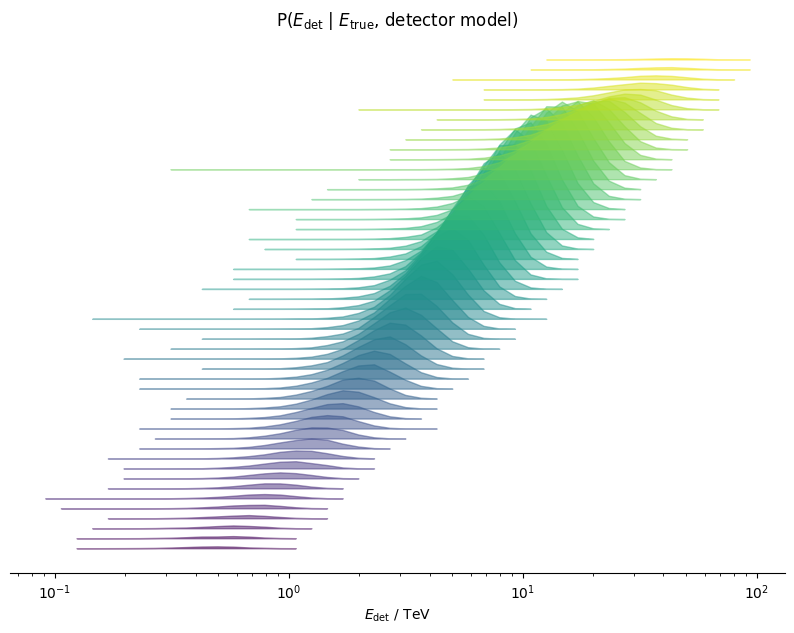

In [7]:
response = Response(initial_energy, true_energy, detected_energy,
                    simulation.effective_area.maximum,
                    nbins_true_energy=50, nbins_detected_energy=50)

response.show()

The above plot shows the response matrix separated out into separate true/initial energy bins. What we have is essentially proportional to a probability distribution, the probability to detect counts with some energy in the detector, given that counts of some true energy are incident upon it. 

We cannot *invert* the matrix to get the true energies for a set of detected energies, because we only know what these could be in a probabilistic sense.

We can also show the matrix directly:

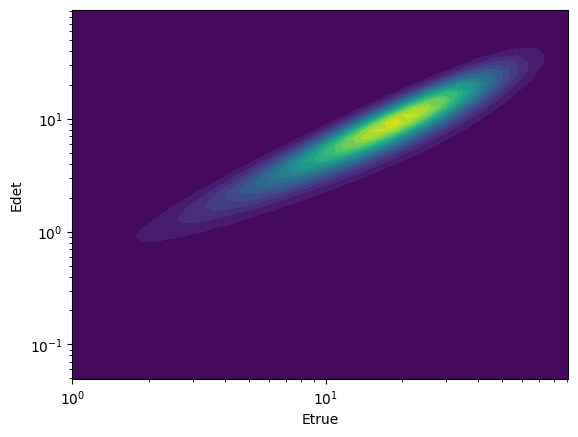

In [8]:
fig, ax = plt.subplots()
ax.contourf(response.true_energy_bins[:-1], response.detected_energy_bins[:-1], 
            response.matrix.T, 20)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Etrue")
ax.set_ylabel("Edet");

In this simple example, the response matrix is *model independent*, as we divide through by the number of counts in the injected spectrum for each bin. In realistic cases, this can be more difficult to take into account.

### Comparing a model with data

Now that we have quantified the instrument response, we can look at how to use this to compare a model with data. First, let's simulate some example data using the same detector model as was used to generate the response.

In [9]:
true_power_law_index = 2.0
N = int(5e2)
data_file = "output/toy_sim_data_pl.h5"

simulation = ToySimulation(true_power_law_index, min_energy, max_energy)
simulation.run(N, seed=random_seed)
simulation.save(data_file)

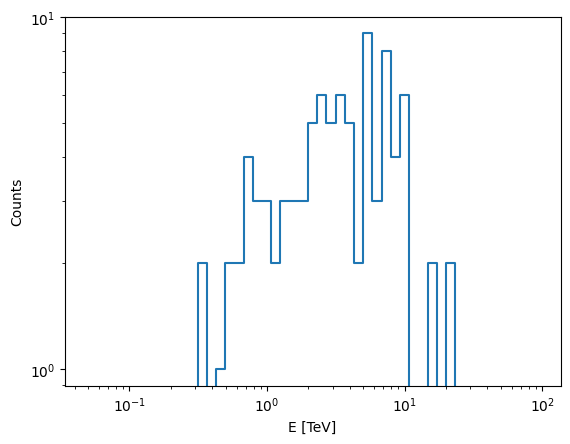

In [10]:
# Have a look at our "data"
with h5py.File("output/toy_sim_data_pl.h5", 'r') as f:
    detected_energy = f['detected_energy'][()]

bins = response.detected_energy_bins
dE = np.diff(bins)

# convert detected energies to rate in channels
counts, _ = np.histogram(detected_energy, bins=bins)

fig, ax = plt.subplots()
ax.step(bins[:-1], counts, where="pre")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [TeV]")
ax.set_ylabel(r"Counts");

### Forward folding

Now let's consider a model for the energy spectrum, say $\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E} \propto E^{-\alpha}$. We want to use our observed data to infer $\alpha$. To do this, we select some value of $\alpha$, then fold our model through the instrument response to compare with the data. This *forward folding* is a convolution, or matrix multiplication of the model with the response.

In our case, we know the true $\alpha$ from the above simulation, so we can just forward fold to demonstrate that we are able to match the data well. In reality, we would try many different values of $\alpha$, and compare each to the data with a statistical method to asses which on provides the "best fit".

In [11]:
# Model
from instrument_response.power_law import BoundedPowerLaw

alpha = 2.0
power_law = BoundedPowerLaw(alpha, min_energy, max_energy)

In [12]:
# Normalise our model to match the simulated flux
def differential_flux(e, F_N, pl):
    return F_N * pl.pdf(e)

# Integral of the differential flux (Simpson's rule)
def integral(e1, e2, F_N, pl):
    return ((e2 - e1) / 6.0) * (differential_flux(e1, F_N, pl) 
                              + 4 * differential_flux((e1 + e2) / 2.0, F_N, pl) 
                              + differential_flux(e2, F_N, pl))

# For our model, calculate the rate in each true energy bin
counts_per_area = integral(response.true_energy_bins[:-1], response.true_energy_bins[1:], simulation.total_dN_dtdA, power_law)

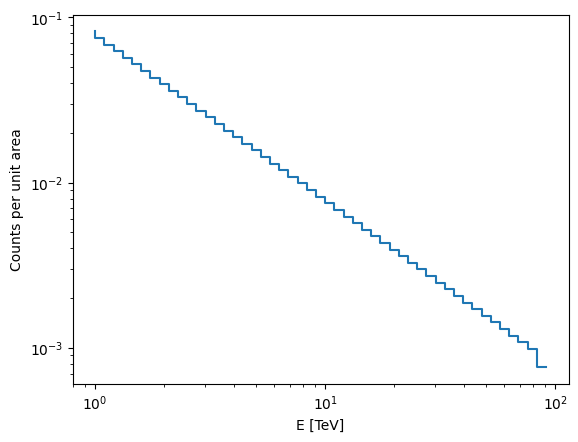

In [13]:
fig, ax = plt.subplots()

ax.step(response.true_energy_bins[:-1], counts_per_area, where='pre')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("E [TeV]")
ax.set_ylabel(r'Counts per unit area');

As expected, our model is a power law with index $\alpha=2$.


In [14]:
# Get folded counts in the detector by taking the dot product with the response
counts_model = np.dot(counts_per_area, response.matrix) # dN/dtdA * dA -> dN/dt 

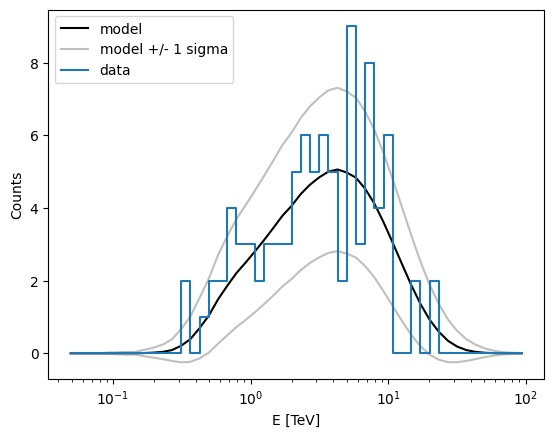

In [15]:
# Compare folded model and data
fig, ax = plt.subplots()

ax.plot(bins[:-1], counts_model, label="model", color="k")
ax.plot(bins[:-1], counts_model + np.sqrt(counts_model), color="grey", alpha=0.5)
ax.plot(bins[:-1], counts_model - np.sqrt(counts_model), label="model +/- 1 sigma", color="grey", alpha=0.5)
ax.step(bins[:-1], counts, where="pre", label="data")
ax.set_xscale("log")
ax.set_xlabel("E [TeV]")
ax.set_ylabel("Counts")
ax.legend();

Again, as expected, we have a good match between the model and data in the energy range of our detector. 

**Exercise 2.1**
We can already see that comparing the model and data in this way can be a way to quantify the "goodness-of-fit", which is basically how well the model is able to represent the data. 

What would a bad representation of the data look like? For the same simualted dataset, evaluate a power-law model with a different value or values of $\alpha$ and visualise the resulting mismatch.

In [16]:
# To be completed...

### Fitting a model to data

In [17]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from cmdstanpy import CmdStanModel

from instrument_response.detector import Response

In [18]:
random_seed = 1

In [19]:
# Load response
response_file = "output/response_sim.h5"
with h5py.File(response_file, 'r') as f:
    initial_energy = f["initial_energy"][()]
    true_energy = f["true_energy"][()]
    detected_energy = f["detected_energy"][()]
    effective_area_max = f["effective_area_maximum"][()]

response = Response(initial_energy, true_energy, detected_energy, effective_area_max, 
                    nbins_true_energy=50, nbins_detected_energy=50)

### Binned likelihood approach
For this simple fitting example, we can fold our model spectrum through the instrument response to compare with the data in the fit. We will use Hamiltonian Monte Carlo as implemented in `Stan` to determine which model parameters best describe our data.

The likelihood is
$$
p(n | \alpha, F_N) = \prod_{i=1}^{N_{\rm{bins}}} \frac{s_i^{n_i}e^{-s_i}}{n_i!},
$$

where $s_i$ are the expected counts in each energy bin (or *channel*), computed by folding the model through the repsonse, and $n_i$ are the actual observed counts in each energy bin.

In [20]:
# View the Stan implementation of the above likelihood
!cat stan/binned_likelihood.stan

/**
 * Fit detected data by forward folding through
 * a response matrix.
 *
 * The model is a power law.
 * @author Francesca Capel
 * @date March 2025
 */

functions {

  /* Define functions to match implementation in 02-forward-folding.ipynb */

  /**
   * Bounded power law to match the implementation in instrument_response/toy_simulation.py
   */
  real bounded_power_law(real E, real alpha, real min_energy, real max_energy) {

    real norm = (1-alpha) * ( pow(max_energy, 1-alpha) - pow(min_energy, 1-alpha) ); 

    if (E < min_energy || E > max_energy) {
      return 0;
    }
    else {
      return norm * pow(E, -alpha);
    }
  }

  /**
   * F_N * power law 
   */
  real differential_flux(real E, real F_N, real alpha, real min_energy, real max_energy) {

    return F_N * bounded_power_law(E, alpha, min_energy, max_energy);
  }

  /**
   * Integrate the differential flux using Simpson's rule
   */
  row_vector integral(vector Ebins, real F_N, real alpha, real min_energy, real max

In [21]:
# Compile the Stan model
model = CmdStanModel(stan_file="stan/binned_likelihood.stan")

In [22]:
# Run the fit
fit_input = {}
fit_input["Nbins_true"] = response.nbins_true_energy
fit_input["Nbins_detected"] = response.nbins_detected_energy
fit_input["min_energy"] = 1 # TeV
fit_input["max_energy"] = 100 # TeV
fit_input["n"] = counts
fit_input["response_matrix"] = response.matrix
fit_input["true_energy_bins"] = response.true_energy_bins
fit_input["detected_energy_bins"] = response.detected_energy_bins

fit = model.sample(data=fit_input, iter_sampling=1000, chains=4)

16:39:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:40:11 - cmdstanpy - INFO - CmdStan done processing.


In [23]:
# check the results
print(fit.diagnose())
fit.summary()

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-55.097600,2.852890e-02,1.006740,0.685109,-57.147800,-54.760200,-54.160400,1475.70,1647.67,1.00060
F_N,1.067880,4.473870e-03,0.164960,0.161847,0.817813,1.057110,1.360660,1367.93,1676.11,1.00081
alpha,2.033220,3.271520e-03,0.121693,0.121447,1.828620,2.035600,2.225020,1398.92,1420.64,1.00104
model_flux[1],0.097269,6.977230e-04,0.024729,0.024279,0.060357,0.095231,0.141787,1254.08,1508.30,1.00139
model_flux[2],0.088217,6.072630e-04,0.021530,0.021213,0.056001,0.086558,0.126721,1254.57,1496.06,1.00145
...,...,...,...,...,...,...,...,...,...,...
s[46],0.015154,1.099680e-04,0.004611,0.004089,0.008970,0.014420,0.023861,1869.52,1555.50,1.00077
s[47],0.004573,3.451480e-05,0.001437,0.001268,0.002665,0.004339,0.007292,1847.91,1575.20,1.00078
s[48],0.000977,7.556320e-06,0.000313,0.000276,0.000563,0.000924,0.001569,1834.75,1561.61,1.00079
s[49],0.000156,1.256490e-06,0.000052,0.000045,0.000088,0.000147,0.000254,1814.07,1492.61,1.00080


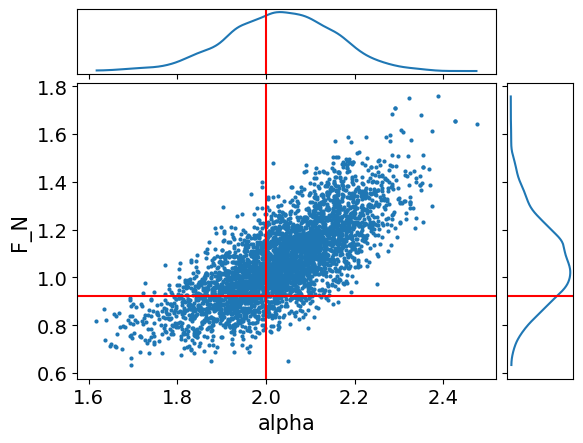

In [24]:
# Load true values from earlier simulation
with h5py.File("output/toy_sim_data_pl.h5", 'r') as f:
    true_alpha = f["power_law_index"][()]
    true_F_N = f["flux_normalisation"][()]

ax = av.plot_pair(fit, var_names=["alpha", "F_N"], marginals=True)
ax[0,0].axvline(true_alpha, color="red")
ax[1,0].axvline(true_alpha, color="red")
ax[1,0].axhline(true_F_N, color="red")
ax[1,1].axhline(true_F_N, color="red")

We can see that the fit recovers the true values, but due to the limited amount of data there are some uncertainties on the fit parameters `F_N` and `alpha`. We can also show the fit results in the "model space" ie. what flux this implies. From above, we can recall that our flux is simply `F_N * power_law(alpha)`.

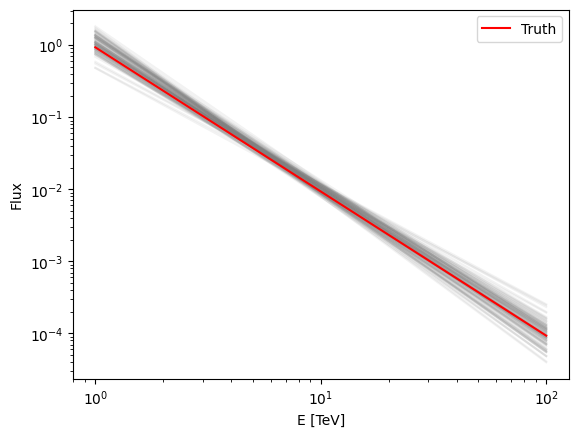

In [25]:
# Values of F_N and alpha from the fit
fit_alpha = fit.stan_variable("alpha")
fit_F_N = fit.stan_variable("F_N")

energy_grid = np.geomspace(min_energy, max_energy)

fig, ax = plt.subplots()

# Evaluate the model for first 100 samples
for i in range(100):
    power_law_tmp = BoundedPowerLaw(fit_alpha[i], min_energy, max_energy)
    ax.plot(energy_grid, fit_F_N[i] * power_law_tmp.pdf(energy_grid), color="grey", alpha=0.1)

# Truth from plot above
ax.plot(energy_grid, true_F_N * power_law.pdf(energy_grid), color="red", label="Truth") 

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("E [TeV]")
ax.set_ylabel(r"Flux")
ax.legend()

But, to judge the goodness-of-fit, we should *forward fold* our model through the instrument repsonse so that we can see what it looks like in the "data space".

**Exercise 2.2:** Add the predictions of the model assumptions plotted above to the plot below. The signal in each energy bin predicted by the fit can be accessed by the variable `fit.stan_variable("s")`. This contains an array of values for each iteration of the chain from MCMC.

Would you say this is a good fit to the data? How could we quantify the goodness-of-fit in each energy bin? Hint: We have a poisson likelihood for the signal prediction. 

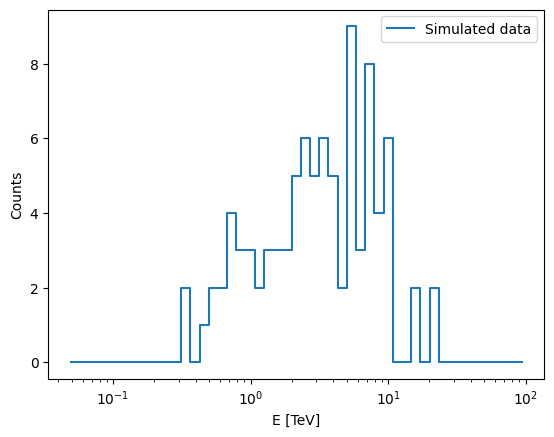

In [26]:
# Look at samples of folded model counts in data space
signal = fit.stan_variable("s")

fig, ax = plt.subplots()
ax.step(response.detected_energy_bins[:-1], fit_input["n"], where="pre", label="Simulated data")

# To be completed...

ax.set_xscale("log")
ax.set_xlabel("E [TeV]")
ax.set_ylabel(r"Counts")
ax.legend();

**Take-away message:** The spectrum fit to the data encodes a model assumption (power law, energy range) and results of the fit (spectral index). If we want to compare some theoretical prediction that is different from this to the data, *we need to do full forward folding to the data space*, to see if this new model can represent our data. It is not sufficient to compare in the model space, although this is often done to give some idea.

E.g. Batista et al. (2019):

<br>

<img src="figures/batista-2019-flux-comp.png" width="600"/>

